<h2> Spectroscopic data reduction : spectra module
    
<h3> KOSMOS demo

Start with some basic imports: we will be using the tv, imred, and spectra modules of pyvista

In [1]:
from pyvista import imred, tv, spectra
import numpy as np
import matplotlib.pyplot as plt

pyvista uses a display tool defined in the tv module. To use the interactive
display in a notebook, set the display to be an external display window, e.g. with 
<code>
%matplotlib qt
</code>
Instantiate a tv object, here we just call it t, but you could call it whatever you want!

In [2]:
# Use these lines if you are running the notebook yourself. Matplotlib
# window will open outside the notebook, which is the desired behavior so
# you can have a single display tool, which you should leave open. Other
# plot windows will also appear outside the notebook, which you can close
# as desired
%matplotlib qt
t=tv.TV()
plotinter=True

# following lines only for fully non-interactive demo of notebook
#%matplotlib inline
#plotinter=False
#t=None

The tool for basic image reduction is a Reducer object, defined in the imred module. Instantiate a reducer here. The main argument is an instrument name, which tells it to read a YAML configuration file for the specified instrument, which sets up things like gain, readout noise, saturation value, etc. We also give it an optional dir= argument to specify the default directory from which to read images, if a directory is not specified in subsequent commands that read images.

In [3]:
# put directory name with images here
indir='/home/holtz/red/UT211030/kosmos/'
red=imred.Reducer('KOSMOS',dir=indir)

INSTRUMENT: KOSMOS   config: 
  will use format:  /home/holtz/red/UT211030/kosmos//*{:04d}.f*.fits*
         gain:  [0.6]    rn: [ 5.]
         scale:  None   
  Biastype : 1
  Bias box: 
    SC    NC    SR    NR
  2055    43    20  4056 
  2105    43    20  4056 
  Trim box: 
    SC    NC    SR    NR
     0  2048     0  4096 
     0  2048     0  4096 
  Norm box: 
    SC    NC    SR    NR
  1000    51  2000    51 


One method of a Reducer object is log(), which reads all of the headers of files in the default directory, and provides summary information

In [4]:
help(red.log)

Help on method log in module pyvista.imred:

log(files=None, htmlfile=None, ext=None, hdu=0, channel='', cols=None, display=None) method of pyvista.imred.Reducer instance
    Create chronological image log from file headers in default
        directory.
    
        If any .csv file exists in the directory, its contents are
        added as a table to htmlfile
    
    Parameters
    ----------
    htmlfile : str, default=None
               if specified, write HTML log to htmlfile
    ext : override default extension to search
    cols : array-like, str, specifies which FITS header cards to output,
           default=None, which will use cards
           as defined in the Reducer object, if they have been set
           by configuration file, or, otherwise will use
           ['DATE-OBS','OBJNAME','RA','DEC','EXPTIME']
    display : if not None, specifies tv tool in which to 
           display each image and make png thumbnail, to include
           in htmlfile
    
    Returns
    -

In [5]:
red.log().show_in_notebook(display_length=10)

file /home/holtz/red/UT211030/kosmos/BD28d4211.0009.fits does not have DATE-OBS


KeyError: "Keyword 'OBJNAME' not found."

A main method of the reducer object is the reduce() method. Without any additional arguments, reduce() will read an image from disk, subtract the overscan (region(s) as determined from the instrument configuration file), compute an uncertainty array using the gain and readout noise from the instrument configuration file, and return a pyvista Data object with the data, uncertainty, and mask. 
<p>
To specify the input image, we could pass a string with the file name. If the string does not include a '/', it will read from the default input directory.
<p>
If the file can be identified with a unique integer, then you can just specify this number, which can be very convenient. This is turned into a character string using the formstr attribute defined in the configuration file, which is used to search for the file to read.
<p>

If you want to read the raw image, with no overscan subtraction, you can use the rd() method.

In [6]:
a=red.reduce(12)

  Reading file: /home/holtz/red/UT211030/kosmos/GP013_parad.0012.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


The resulting Data object has attributes: header, data, uncertainty, and bitmask, which are carried along through the processing.

For example, to see the header:

In [7]:
a.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2148                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
OBSERVAT= 'APO'                / Per the IRAF observatory list.                 
TELESCOP= '3.5m'                                                                
INSTRUME= 'kosmos'             / Instrument name                                
LATITUDE= +3.2780361000000E+01 / Latitude of telescope base                     
LONGITUD= -1.0582041700000E+02 / Longitude of telescope base                    
UTC-TAI = -37.0                / UTC = TAI + UTC_TAI(seconds)                   
UT1-TAI = -37.10            

We can display the image using the tv() method of our display tool, which can take as input a Data object, a numpy array, or a FITS HDU object>

In [8]:
if t is not None: 
    t.tv(a)

Inside the display tool, you can use mouse buttons to zoom in and out and pan, and there are a number of other convenience keys (use h key for help). Warning: while you can use the matplotlib navigation, the built-in mouse button response will confuse things; if you just prefer the matplotlib navigation, you can toggle the pyvista mouse commands on/off with the Z key.

The uncertainty is stored as a standard deviation, with values in the uncertainty.array attribute, e.g.:

In [9]:
if t is not None:
    t.tv(a.uncertainty.array)

The tv() method has a convenience keyword, sn=, which can be used to display the S/N of an image, i.e. a.data/a.uncertainty.array

In [10]:
if t is not None :
    t.tv(a,sn=True)

The bitmask attribute of a Data object can carry along information about different types of pixels, e.g. bad pixels, saturated pixels, etc.

In [11]:
if t is not None :
    t.tv(a.bitmask)

<h4> Calibration: make and apply flat field

If we add additional arguments to reduce(), we can add additional calibration steps. For example, to flat field the data, we would add a flat= keyword through which we give the reducer a flat field.
<p>
First, however, we have to make the flat field, which is accomplished using the mkflat() method, which takes as input a list of frames to be used to construct the master flat field (superflat). For a spectrograph, we use the spec=True keyword which will remove the spectral signature from the combined flat.
<p>
If you specify a pyvista TV tool with the display= keyword, mkflat() will display the final flat field, then each individual input frame divided by
the final flat, so you can inspect and confirm that all input frames are similar. You will need to enter a space in the display window after each
image is displayed to proceed to the next, as prompted by the output.
<p>
Note the littrow= keyword, which can be used to attempt to remove the Litrrow ghost from the flat, but its location needs to be identified in the input image bitmasks.

In [12]:
flatims=[18,19,20,21,22]
flat=red.mkflat(flatims,spec=True,display=None,littrow=False)

  Reading file: /home/holtz/red/UT211030/kosmos/flat.0018.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /home/holtz/red/UT211030/kosmos/flat.0019.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /home/holtz/red/UT211030/kosmos/flat.0020.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /home/holtz/red/UT211030/kosmos/flat.0021.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /home/holtz/red/UT211030/kosmos/flat.0022.fits
  subtracting overscan vector 
  subtracting overscan vector 
  combining data with median....
  calculating uncertainty....


Here we display the flat, and demonstrate the use of the min= and max= keywords in the tv() method, which set the image display scaling manually.

In [13]:
if t is not None :
    t.tv(flat,min=0.5,max=1.5)

Here we use the reduce() method to read, overscan subtract, and flat field an image, then display it.

In [14]:
star=red.reduce(10,flat=flat)
if t is not None:
    t.tv(star,max=1000) 

  Reading file: /home/holtz/red/UT211030/kosmos/BD28d4211.0010.fits
  subtracting overscan vector 
  subtracting overscan vector 
  flat fielding...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


Here is an example of attempting cosmic ray rejection. CR rejection can be challenging; the main concern is that the cosmic ray rejection flags object pixels as cosmic rays! Users should be very careful about this. The Reducer object provides two algorithms for CR-rejection. If crbox='lacosmic", then the LA Cosmic routine of van Dokkum, as implemented
in the astroscrappy package, is used. If crbox=[nrow,ncol], then the image
is median-filtered with the specfied box shape, and pixels above nsig (default=5) times the uncertainty are replaced with the median; if multiple values of crsig are input as a list (e.g., crsig=[5,2], then multiple iterations are done, where iterations after the first only apply to neighbors of CRs identified in previous iterations. For spectroscopy, beware: a box aligned with the wavelength direction will avoid flagging pixels in the object, but may flag pixels in sky lines, while the reverse is true for a box aligned along the slit.

If you specify the display= keyword and pass a display tool, then the routine will show you the identified, CRs, the cleaned image, and the original image. This demonstrates the rolling buffer of the TV tool, which saves 4 images that can be cycled through using the '-' and '+/=' keys to move through the stack.

In [15]:
# Following would use a simple thresholded median filter
#crstar=red.crrej(star,crbox=[9,1],crsig=[5,2],display=t)
# Following uses lacosmic
crstar=red.crrej(star,crbox='lacosmic',display=t)

  zapping CRs with astroscrappy detect_cosmics
  See CRs and CR-zapped image and original using - key
   To continue, hit space in display window (p for debug) 


For lacosmic, the astroscrappy routine does not use an input uncertainty array, so can incorrectly flag pixels after flat fielding, if the flat field has a lot of dynamic range.

Note that you can include cosmic ray rejection in the reduce() method by adding a crbox= (and, optionally, a crsig=) keyword, in which case, the CR rejection is done <b> before </b> the flat fielding.

Notice that if you use the display= keyword in reduce(), it will display images at each stage of the reduction so you can inspect, after which you will need to enter a space in the display window to continue.

In [17]:
star=red.reduce(10,crbox='lacosmic',flat=flat,display=t)

  Reading file: /home/holtz/red/UT211030/kosmos/BD28d4211.0010.fits
  subtracting overscan vector 
  subtracting overscan vector 
  See bias box (solid outlines applied to dashed regions of the same color), and cross section. 
   To continue, hit space in display window (p for debug) 
  zapping CRs with astroscrappy detect_cosmics
  See CRs and CR-zapped image and original using - key
   To continue, hit space in display window (p for debug) 
  flat fielding...
  See flat-fielded image and original with - (minus) key.
   To continue, hit space in display window (p for debug) 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


<h4> Tracing and extraction

We want to extract the spectrum, i.e. from the 2D image to a 1D spectrum. Start with a trace previously determined for KOSMOS. The Trace object sets the order of the polynomial used to fit the trace (degree attribute), the length of the slit (rows attribute), the range of pixels along the slit to be used to automatically find an object, etc.

In [18]:
trace=spectra.Trace('KOSMOS/KOSMOS_trace.fits')
vars(trace) 

{'type': 'Polynomial1D',
 'degree': 2,
 'sc0': 2048,
 'pix0': 0,
 'spectrum': array([    0.,     0.,     0., ...,  3448.,  3443.,  3442.]),
 'rad': 5,
 'lags': array([-300, -299, -298, -297, -296, -295, -294, -293, -292, -291, -290,
        -289, -288, -287, -286, -285, -284, -283, -282, -281, -280, -279,
        -278, -277, -276, -275, -274, -273, -272, -271, -270, -269, -268,
        -267, -266, -265, -264, -263, -262, -261, -260, -259, -258, -257,
        -256, -255, -254, -253, -252, -251, -250, -249, -248, -247, -246,
        -245, -244, -243, -242, -241, -240, -239, -238, -237, -236, -235,
        -234, -233, -232, -231, -230, -229, -228, -227, -226, -225, -224,
        -223, -222, -221, -220, -219, -218, -217, -216, -215, -214, -213,
        -212, -211, -210, -209, -208, -207, -206, -205, -204, -203, -202,
        -201, -200, -199, -198, -197, -196, -195, -194, -193, -192, -191,
        -190, -189, -188, -187, -186, -185, -184, -183, -182, -181, -180,
        -179, -178, -177, -

Mote that for working with spectra, pyvista uses the horizontal dimensiona s the wavelength dimension. If wavelength is in the vertical direction (as it is for KOSMOS), set transpose=True, and images will be transposed.

Instead of using a predefined trace, you caninstantiate a fresh Trace object, specifying whether your input images have wavelength along columns (transpose=False) or rows (transpose=True), and specifying the extent of the slit with the rows= keyword. Other keywords allow you to specify other attributes, see the help.

In [19]:
mytrace=spectra.Trace(transpose=True,rows=[550,1450])
vars(mytrace)

{'type': 'Polynomial1D',
 'degree': 2,
 'sigdegree': 0,
 'pix0': 0,
 'spectrum': None,
 'rad': 5,
 'transpose': True,
 'lags': range(-50, 50),
 'rows': [550, 1450],
 'model': None,
 'sigmodel': None,
 'sc0': None}

We can use the existing trace to retrace a new spectrum. This is done by cross-correlating the reference spectrum with a spatial cut across the input spectrum (at sc0) to find the shift, then using the old model to start the trace from that starting position. The functional form of the old model is preserved.

If the display= keyword is specified, the display will show the derived traces centers (green points), and the polynomial fit to these (magenta line) that defines the trace. You will need to hit the space bar in the display window to proceed.

In [20]:
trace.retrace(star,display=t)

  Derived pixel shift from input trace:  0.0254601337879
Using shift:  0.0254601337879


/home/holtz/git/pyvista/python/pyvista/spectra.py:1130: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) )[0]
/home/holtz/git/pyvista/python/pyvista/spectra.py:1141: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) & (np.abs(res)<rad))[0]



  See trace. Hit space bar to continue....


There are various alternatives for finding traces:

A. one could use the find() method to determine the shift between the stored trace and your frame automatically with cross correlation, then just go straight to extraction using the shape of the stored trace; this would be applicable if your object is too faint, or doesn't have sufficient continuum, to trace. If you want to mark the location of the object manually, use the inter=True keyword (along with display=) in find(). 


In [20]:
trace.model[0](2048)
if t is not None:
    trace.find(star,inter=True,display=t)
print(trace.pix0)

0


B. You can just find peak(s) in the spatial direction using findpeak(), then trace then. You specify a threshold in S/N to identify peaks.

Note that the trace object has the flexibility to find use multiple objects along the slit.

In [21]:
peaks,ids=trace.findpeak(star,thresh=50)
                            
trace.trace(star,peaks,display=t)

looking for peaks using 200 pixels around 2048, threshhold of 50.000000
peaks:  [394]
aperture/fiber:  [0]
  Tracing row: 944


<Figure size 432x288 with 0 Axes>

The model is now modified for the input spectrum:

In [22]:
trace.model[0](2048)

943.8185449238722

C. If you needed to create Trace from scratch, instantiate one with rows=, lags=, sc= (transpose= determines whether input image needs to be transposed to get wavelength changing along columns). 
<p>
    Note the skip= keyword which can be used when tracing to speed things up by only computing centroids every skip pixels, taking a median around these pixels of width skip pixels. The default is skip=10

In [23]:
trace=spectra.Trace(sc0=2048,lags=range(-300,300),
                    rows=[550,1450],transpose=red.transpose)
vars(trace)
srow=[955]   # list to allow for multiple spectra on an image, mnaually set
srow,ids=trace.findpeak(star, thresh=50)  # alternatively, find peak(s)
# trace.find(star) will find the highest peak by cross-correlation
# trace.find(star,inter=True,display=t)  will let you mark a trace location
starec=trace.trace(star,srow,display=t,skip=100) 
vars(trace)

looking for peaks using 200 pixels around 2048, threshhold of 50.000000
peaks:  [394]
aperture/fiber:  [0]
  Tracing row: 944


{'type': 'Polynomial1D',
 'degree': 2,
 'sigdegree': 0,
 'pix0': 0,
 'spectrum': array([ 54208.6171875 ,   8355.84960938,      0.        , ...,
         10526.25      ,  22835.43359375,  14175.71191406]),
 'rad': 5,
 'transpose': True,
 'lags': range(-300, 300),
 'rows': [550, 1450],
 'model': [<Polynomial1D(2, c0=936.3451816469812, c1=0.0034208334377593386, c2=1.1122901297644918e-07)>],
 'sigmodel': None,
 'sc0': 2048,
 'index': array([0])}

<Figure size 432x288 with 0 Axes>

Extraction is done using the extract() method of the Trace object, currently just with simple boxcar extraction. Use rad= to specify window radius. Use back=[[b1,b2],[b3,b4]] to subtract background as determined from one or more background windows (note argument should be list of 2-element lists, giving start and end pixel, relative to object location, of each background window).

Note that simple extraction like this does not account for wavelength line curvature, if that is important, see methodology below!

In [21]:
starec=trace.extract(star,display=t,rad=25)
print(starec.shape)

  extracting ... 
  See extraction window(s). Hit space bar to continue....

(1, 4096)


extract() returns a pyvista Data object, with extracted spectrum, and uncertainty. Note that this is a 2D array to accomodate multiple objects/traces, even if there is only a single object.

Here and elsewhere, if you want to make matplotlib plots, make sure to start a new figure (e.g., with plt.figure()) to avoid plotting into the pyvista display tool!

In [22]:
plt.figure()
plt.plot(starec.data[0])
plt.plot(starec.data[0]/starec.uncertainty.array[0])

Background can be subtracted during extraction using the back= keyword, which takes a list of 2-element lists, given the relative location, in pixels, of the background window(s) (relative to the location of the trace):

  extracting ... 



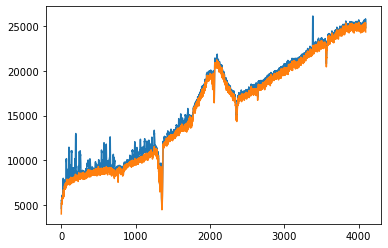

In [26]:
starec2=trace.extract(star,rad=25,back=[[50,75],[-75,-50]],display=t)

plt.figure()
plt.plot(starec.data[0])
plt.plot(starec2.data[0])

<h4> Wavelength calibration

Now let's turn to wavelength calibration, i.e. getting a function that gives the wavelength as a function of pixel. We'll solve for this using arc frames, here taken with each lamp separately, so sum the three exposures (note the sum() method of the Reducer, there's also other combination methods).

In [27]:
#Frame 15 is He, 16 is Ne, and 17 is Ar
arcs=red.sum([15,16,17])
if t is not None:
    t.clear()
    t.tv(arcs)

  Reading file: /home/holtz/red/UT211030/kosmos/He.0015.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/red/UT211030/kosmos/Ne.0016.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/red/UT211030/kosmos/Ar.0017.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  combining data with sum....
  calculating uncertainty....


We'll extract a region of the arcs around our trace.

In [28]:
arcec=trace.extract(arcs,display=None,rad=20)

  extracting ... 



Wavelength calibration first stars with identifying lines. This is much easier if one can work from a previous solution. Here we start by reading a previous solution into a pyvista WaveCal object. A WaveCal object contains a spectrum and identified lines and their associated pixel and wavelength positions. Using this, a solution for a new arc spectrum is found by cross correlating the spectrum with the saved one, and using the derived shift to try to re-identify the same lines as in the saved object.

For KOSMOS, there are previous solutions for low, central, and high slit positions

In [29]:
spectra.WaveCal("?")

available predefined WaveCals: 
ARCES/ARCES_wave.fits
BOSS/BOSS_b2_waves.fits
BOSS/BOSS_b1_waves.fits
BOSS/BOSS_r1_waves.fits
BOSS/BOSS_r2_waves.fits
DIS/DIS_blue_waves.fits
DIS/DIS_red_waves.fits
KOSMOS/KOSMOS_blue_cent_waves.fits
KOSMOS/KOSMOS_blue_high_waves.fits
KOSMOS/KOSMOS_blue_low_waves.fits
KOSMOS/KOSMOS_blue_waves.fits
KOSMOS/KOSMOS_red_high_waves.fits
KOSMOS/KOSMOS_red_low_waves.fits
KOSMOS/KOSMOS_red_waves.fits


Load the appropriate existing WaveCal.

In [30]:
wav=spectra.WaveCal('KOSMOS/KOSMOS_red_low_waves.fits')
vars(wav)

  rms:    0.230 Angstroms (60 lines)


{'type': 'chebyshev',
 'degree': 3,
 'ydegree': 2,
 'waves': array([ 5400.562  ,  5562.22534,  5570.28944,  5572.548  ,  5580.38729,
         5748.299  ,  5764.418  ,  5824.5185 ,  5852.4878 ,  5866.75017,
         5870.91599,  5875.618  ,  5879.90035,  5944.8342 ,  5945.45239,
         5977.64573,  5993.8502 ,  6029.9971 ,  6074.3377 ,  6096.163  ,
         6143.0623 ,  6163.5939 ,  6217.2813 ,  6266.495  ,  6304.7892 ,
         6334.4279 ,  6382.9914 ,  6402.246  ,  6506.5279 ,  6532.8824 ,
         6598.9529 ,  6678.2    ,  6717.0428 ,  6752.832  ,  6871.29   ,
         6965.43   ,  7032.4127 ,  7065.188  ,  7147.041  ,  7173.939  ,
         7245.167  ,  7383.98   ,  7438.899  ,  7635.105  ,  7723.8    ,
         7891.075  ,  7948.175  ,  8082.458  ,  8264.521  ,  8408.208  ,
         8424.647  ,  8521.441  ,  8620.4602 ,  8634.647  ,  8654.3831 ,
         8667.9442 ,  8697.94   ,  8799.0875 ,  8853.866  ,  8919.5007 ]),
 'waves_order': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [31]:
wav.dispersion()

-1.0184165540022461

With a previous solution loaded, the identify routine will cross correlate the input spectrum with the previous solution, then attempt to identify the lines from the previous solution at the shifted pixel position from the previous solution. Finally, it does a fit.

The identify() method fits Gaussians to the lines to get their position, and gets FWHM in the process. rad= keyword specifies number of pixels on either side of line to use in fit. If you add the file= keyword, then the routine will try to identify all of the lines from the reference file; this might be useful if you wanted to extend the wavelength range of the lines from the initial object, e.g. if you were working at a different grating tilt or slit location. If you did that, you might want to save your WaveCal object after cleaning the line list for good lines, so you could use that as a starting guess for other data taken at a similar wavelength setting.

With the plot=True keyword, you'll see plots of the spectrum, identified lines, and residuals from a polynomial fit. You can remove individual lines or groups of lines with keystrokes in the plot window, as instructed.

In [32]:
wav.identify(arcec,plot=True,plotinter=plotinter,rad=10) #,file='henearkr.dat')

  cross correlating with reference spectrum using lags:  range(-300, 300)
  Derived pixel shift from input wcal:  [ 2.76975284]
  See identified lines.
  rms:    2.107 Angstroms (46 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    2.107 Anstroms
  input from plot window...
  rms:    1.982 Anstroms
  input from plot window...
  rms:    0.130 Anstroms
  input from plot window...
  rms:    0.108 Anstroms
  input from plot window...



Note that once you remove lines, they are removed for subsequent uses of the WaveCal object.

If you want to refit with existing line positions, e.g. to try a different model, you can just call fit().

In [33]:
wav.fit(degree=5,inter=plotinter)

  rms:    0.070 Angstroms (46 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    0.070 Anstroms
  input from plot window...


The line centers are found by fitting Gaussians to the spectrum. This is useful because it provides information on the spectral resolution. The derived widths are saved in the fwhm attribute of the WaveCal object.

Plot the FWHM of the lines as a function of wavelength, here in the lower right axes of the display tool.

In [34]:
if t is not None:
    t.plotax2.cla()
    gd=np.where(wav.weights > 0)[0]
    t.plotax2.plot(wav.waves[gd],np.abs(wav.fwhm[gd]),'ro')

OK, now use the wavelength solution to get wavelength as a function of pixel. We can save that in the wave attribute of our Data object.

In [35]:
wav.add_wave(starec)
plt.figure()
plt.plot(starec.wave[0],starec.data[0])

Here is a way to get the inverse wavelength solution, i.e. pixels as a function of wavelength, using a cubic spline fit to the wavelength solution.

In [36]:
# get inverse relation, i.e. pixels as f(wavelength)
pix=np.arange(4096)
from scipy.interpolate import CubicSpline
wav2pix=CubicSpline(np.flip(starec.wave[0]),np.flip(pix))
print('wavelength 6563 expected at pixel: ',wav2pix(6463))

wavelength 6563 expected at pixel:  2462.2516491733877


Next cell demonstrates resampling of spectrum onto a uniform wavelength grid, using the scomb() method of the WaveCal object. This may not be desired, as it leads to correlated uncertainties between pixels! But it would be needed if, e.g., you wanted to cross-correlate spectra to find velocities, in which case you would want a spectrum with constant dispersion in log(lambda).

/home/holtz/git/pyvista/python/pyvista/spectra.py:772: RuntimeWarning: invalid value encountered in true_divide
  out = out / sig
/home/holtz/git/pyvista/python/pyvista/spectra.py:773: RuntimeWarning: divide by zero encountered in true_divide
  sig = np.sqrt(1./sig)


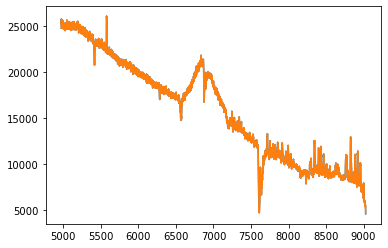

In [37]:
plt.figure()
plt.clf()
# original data with wavelength solution
plt.plot(starec.wave[0],starec.data[0])

# set desired new wavelength scale:
wnew=10**np.arange(3.5,4.0,5.5e-6)
# resampled data on constant log(lambda) grid
plt.plot(wnew,wav.scomb(starec,wnew).data)

<h4> Adjusting wavelength solution for flexure

It is known that line positions shift in KOSMOS with rotator angle. While one strategy to deal with this might be to take calibration data at each rotator angle, one might also attempt to solve for the shift using sky lines.

Reduce an object, extract, add wavelengths, and plot

In [38]:
objec=trace.extract(red.reduce(12),display=t,rad=20)
wav.add_wave(objec)

  Reading file: /home/holtz/red/UT211030/kosmos/GP013_parad.0012.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  extracting ... 



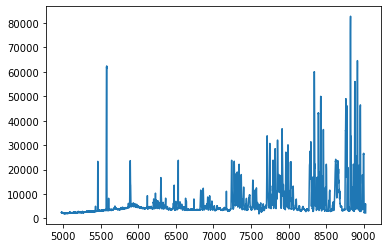

In [39]:
plt.figure()
plt.plot(objec.wave[0],objec.data[0])

The skyline() method will addjust the current wavelength solution based on finding sky emission lines. The default behavior is to adopt the current wavelength solution but allow only the 0th order term to shift. If you specify linear=True, then the 1st order term is also allowed to vary; beware that you must have multiple sky lines for this to be effective! Otherwise, skyline() takes most of the same keywords as identify()
<p>
Note that this currently allows for a wavelength shift, while one might really prefer a pixel shift to model flexure. So long as the dispersion is close to linear, these do the same thing, but future improvements might include doing a more proper pixel shift.
    
<p>
Here, we first copy the WaveCal object so we can compare the original to the corrected solution.

  See identified lines.
  rms:    2.263 Angstroms (17 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    2.263 Anstroms



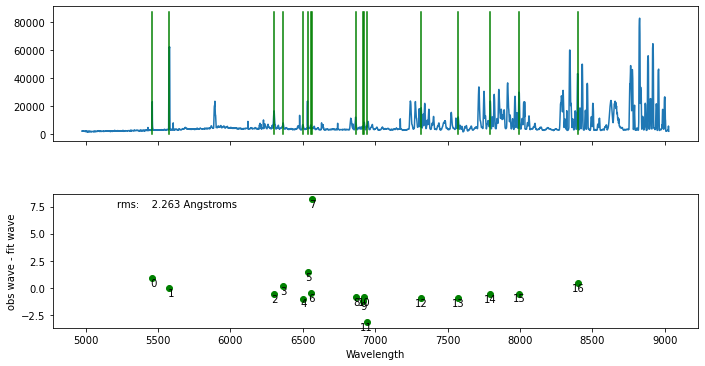

In [40]:
import copy
swav=copy.deepcopy(wav)
swav.skyline( objec, thresh=50, inter=plotinter)

See how the model has been modified compared to the original:

In [41]:
print(wav.model)
print(swav.model)

Model: Chebyshev1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 5
Domain: (726.33296997722334, 4139.4718565518451)
Parameters:
          c0            c1             c2            c3            c4              c5      
    ------------- -------------- ------------- ------------- -------------- ---------------
    7093.52640398 -1737.90042423 32.2615164716 12.1645498761 0.139722117838 0.0262301981787
Model: Chebyshev1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 5
Domain: (726.33296997722334, 4139.4718565518451)
Parameters:
          c0            c1             c2            c3            c4              c5      
    ------------- -------------- ------------- ------------- -------------- ---------------
    7093.81429727 -1737.90042423 32.2615164716 12.1645498761 0.139722117838 0.0262301981787


You can see that the c0 term has changed.

<h4> Flux calibration

Flux calibration is achieved by observing standard stars with known spectral energy distribution. Multiple standards can be loaded and then a single response curve fit to them. Note that if standards are observed at multiple airmasses and different from that of the object, that atmospheric extinction will lead to different observed fluxes relative to true one; to account for that, we can use mean extinction coefficients to correct spectra to the same airmass.

To do flux calibration, instantiate a FluxCal object. You can set it up to use a polynomial fit to the response curve by specifying the polynomial degree with the degree= keyword. If you set degree=-1, the response curve will be determined by a median of the individual response curves, optionally smoothed with a median filter over wavelength (see response() method below).

Currently, regions around significant absorption lines (telluric and stellar) are masked out. As a result, telluric absorption is <b> not </b> corrected by flux calibration. Future work might attempt to do this, or perhaps there should be another module for telluric absorption removal.

In [42]:
flx=spectra.FluxCal(degree=-1)
polyflx=spectra.FluxCal(degree=5)

Load in several extracted spectra of flux standards, here all of BD+28 4211. The standard star spectrum is given using the file= keyword, where the input file should have labelled columns wave, flux, and bin. Alternatively, you can pass an astropy Table with (at least) these three columns, using the stdflux= keyword

In [43]:
for im in [10,11] :
    star=red.reduce(im)
    trace.retrace(star)
    starec=trace.extract(star)
    wav.add_wave(starec)
    flx.addstar(starec[0],starec.wave[0],file='flux/okestan/fbd28d4211.dat')
    polyflx.addstar(starec[0],starec.wave[0],file='flux/okestan/fbd28d4211.dat')

  Reading file: /home/holtz/red/UT211030/kosmos/BD28d4211.0010.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Derived pixel shift from input trace:  -0.0508267535137
Using shift:  -0.0508267535137


/home/holtz/git/pyvista/python/pyvista/spectra.py:1126: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) )[0]
/home/holtz/git/pyvista/python/pyvista/spectra.py:1137: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) & (np.abs(res)<rad))[0]



  extracting ... 

  Reading file: /home/holtz/red/UT211030/kosmos/BD28d4211.0011.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Derived pixel shift from input trace:  -0.21185874283
Using shift:  -0.21185874283
  Tracing row: 943
  extracting ... 



<Figure size 432x288 with 0 Axes>

Solve for the median response curve, taking a median filter over this median.

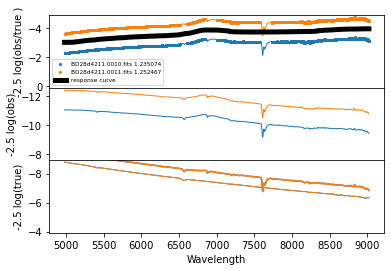

In [44]:
flx.response(plot=True,medfilt=200)

Here's the same with a polynomial response curve.

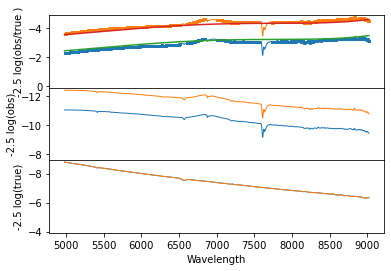

In [45]:
polyflx.response(plot=True)

Apply the response curve to an object using the correct() method of the FluxCal object. Note that, using Data objects, the S/N is preserved!

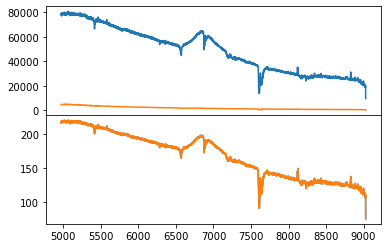

In [46]:
fig,ax=plots.multi(1,2,hspace=0.001,sharex=True)
ax[0].plot(starec.wave[0],starec.data[0])
ax[1].plot(starec.wave[0],starec.data[0]/starec.uncertainty.array[0])
flx.correct(starec,starec.wave)
ax[0].plot(starec.wave[0],starec.data[0])
ax[1].plot(starec.wave[0],starec.data[0]/starec.uncertainty.array[0])

<h3> longslit extraction and wavelength calibration

For extended objects, and perhaps for sky subtraction, we might want to work along the slit. The wavelength solution varies along the slit (line curvature), usually with more than just an offset, so we will derive a 2D wavelength solution.

Start by working along the slit to identify lines. This is achieved with the extract2d() method, which uses a trace of the same shape, but steps it along the slit. It will only extract within the region specified by the rows= attribute of the Trace object.

Future work could include the possibility of varying trace shape along the slit.

In [55]:
trace=spectra.Trace('KOSMOS/KOSMOS_trace.fits')
arc2d=trace.extract2d(arcs)
if t is not None :
    t.tv(arc2d)

[ 550 1450]


If we give the identify() method a 2D image, it steps along by nskip pixels to identify lines along the slit.

In [37]:
wav=spectra.WaveCal(file='KOSMOS/KOSMOS_red_low_waves.fits')

# here, we smooth along the slit first
from pyvista import image
image.smooth(arc2d,[5,1])

if t is not None :
    t.clear()
    t.tv(arc2d)
    
wav.identify(arc2d, rad=10,display=t, plot=True, plotinter=plotinter,
              nskip=20,lags=np.arange(-10,10))
wav.add_wave(arc2d)

  rms:    0.230 Angstroms (60 lines)
  cross correlating with reference spectrum using lags:  [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]
xcorr peak fit failed, row:  0  using peak
xcorr peak fit failed, row:  1  using peak
xcorr peak fit failed, row:  2  using peak
xcorr peak fit failed, row:  3  using peak
xcorr peak fit failed, row:  4  using peak
xcorr peak fit failed, row:  5  using peak
xcorr peak fit failed, row:  6  using peak
xcorr peak fit failed, row:  7  using peak
xcorr peak fit failed, row:  8  using peak
xcorr peak fit failed, row:  9  using peak
xcorr peak fit failed, row:  10  using peak
xcorr peak fit failed, row:  11  using peak
xcorr peak fit failed, row:  12  using peak
xcorr peak fit failed, row:  13  using peak
xcorr peak fit failed, row:  14  using peak
xcorr peak fit failed, row:  15  using peak
xcorr peak fit failed, row:  16  using peak
xcorr peak fit failed, row:  17  using peak
xcorr peak fit failed, row:  18  using pe

In [38]:
wav.plot()

/home/holtz/git/pyvista/python/pyvista/spectra.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


In [54]:
wav.spectrum.shape


(900, 4096)

OK, the solution provides a 2D wavelength map, which we can look at:

In [50]:
if t is not None :
    t.clear()
    t.tv(arc2d.wave)

Subtract out the central wavelength solution to see how the solution varies with row. This is giving the line curvature, which is a function of wavelength

In [51]:
dw=arc2d.wave-arc2d.wave[450]
if t is not None :
    t.tv(dw)  

Now we can do a 2d extraction of an object, and attach the 2D wavelengths

In [52]:
trace=spectra.Trace('KOSMOS/KOSMOS_trace.fits')
obj=red.reduce(12,crbox=[1,9],crsig=[5,2])
if t is not None :
    t.tv(obj)
obj2d=trace.extract2d(obj)
wav.add_wave(obj2d)
if t is not None :
    t.tv(obj2d)


  Reading file: /home/holtz/red/UT211030/kosmos/GP013_parad.0012.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Iteration 0, zapping CRs with filter [1,9]...
  Iteration 1, zapping CRs with filter [1,9]...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


In [53]:
star=red.reduce(10)
star2d=trace.extract2d(star)
wav.add_wave(star2d)

  Reading file: /home/holtz/red/UT211030/kosmos/BD28d4211.0010.fits
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


Here we rectify the image to have a constant wavelength scale (in log lambda). We choose the new scale based on the starting and ending wavelengths in the original image, and resample to get the same number of pixels.

If you preferred not to resample your object (or at least minimize the ressampling), you could resample the image to the wavelength array at the location of your object.

Display image after rectification: the arc lines should be straight!

In [54]:
#get starting and ending wavelengths
wlim=(arc2d.wave[450,0],arc2d.wave[450,-1])
# create new wavelengths in same domain, same number of pixels, but
#   uniformly spaced in log(lambda)
wnew=10.**np.linspace(np.log10(wlim[1]),np.log10(wlim[0]),4095)
print(wnew)
arc2d_rect=wav.correct(arc2d,wnew)
if t is not None :
    t.tv(arc2d)
    t.tv(arc2d_rect)

[ 4962.95599479  4963.68174822  4964.40760777 ...,  9028.15237881
  9029.47260259  9030.79301943]


Now do the same for an object

In [55]:
obj2d_rect=wav.correct(obj2d,wnew)
star2d_rect=wav.correct(star2d,wnew)
if t is not None :
    t.tv(obj2d)
    t.tv(obj2d_rect)

Now the skylines should be straight! Note that the new image goes increases in wavelength from left to right.

Note that the bitmask is propagated to the rectified image, where any output pixel that has a contribution from an input pixel with a bit set, has that same bit set in the output.

In [56]:
if t is not None :
    t.tv(obj2d_rect.bitmask)

OK, now we can extract in the wavelength rectified image for better sky subtraction. Create a new trace object with the rows= attribute to give the new extent of the trimmed image in rows, since our previous extraction limited the extraction to the length of the slit, as set by the rows attribute in the original trace object.

In [57]:
rows=[0,star2d_rect.shape[0]]
trace=spectra.Trace(sc0=int(star2d_rect.shape[1]/2.),rows=rows)
rows,ids=trace.findpeak(star2d_rect,thresh=50)
print('rows: ',rows)
trace.trace(star2d_rect,rows,display=None)

#now apply this to an object
trace.find(obj2d_rect)
#extraction without background subtraction
if t is not None :
    t.clear()
ext=trace.extract(obj2d_rect,rad=20,display=t)
ext.add_wave(wnew)
# and with background subtraction, from farther away
ext_sub=trace.extract(obj2d_rect,rad=20,back=[[50,100]],display=t)
ext_sub.add_wave(wnew)

looking for peaks using 200 pixels around 2047, threshhold of 50.000000
peaks:  [394]
aperture/fiber:  [0]
rows:  [394]


/home/holtz/git/pyvista/python/pyvista/spectra.py:1126: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) )[0]
/home/holtz/git/pyvista/python/pyvista/spectra.py:1137: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) & (np.abs(res)<rad))[0]



xcorr peak fit failed, row:  0  using peak
  Derived pixel shift from input trace:  -50.0
  extracting ... 

  extracting ... 



<Figure size 432x288 with 0 Axes>

Plot to see how good the background subtraction is. Note that variations in line width across the slit will still lead to poorer subtraction.

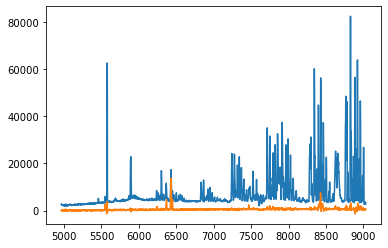

In [58]:
plt.figure()
plt.plot(ext.wave,ext.data[0])
plt.plot(ext.wave,ext_sub.data[0])


CR rejection via multiple image stacking